PSF Creation Started...
Found 12 star images
Processing image 1/12: WFI_2026_OG_region_001.fits
  Center found at: (63.18, 51.07)
    Found 143 negative pixels (min=-1.286e-01) in resampled star
Processing image 2/12: WFI_2026_OG_region_002.fits
  Center found at: (50.16, 43.60)
    Found 195 negative pixels (min=-1.535e-01) in resampled star
Processing image 3/12: WFI_2026_OG_region_003.fits
  Center found at: (70.08, 57.71)
    Found 367 negative pixels (min=-1.329e-01) in resampled star
Processing image 4/12: WFI_2026_OG_region_004.fits
  Center found at: (58.73, 39.41)
    Found 290 negative pixels (min=-1.218e-01) in resampled star
Processing image 5/12: WFI_2026_OG_region_005.fits
  Center found at: (37.25, 33.87)
    Found 212 negative pixels (min=-1.362e-01) in resampled star
Processing image 6/12: WFI_2026_OG_region_006.fits
  Center found at: (36.34, 30.61)
    Found 352 negative pixels (min=-1.123e-01) in resampled star
Processing image 7/12: WFI_2026_OG_region_007.fits
  Ce

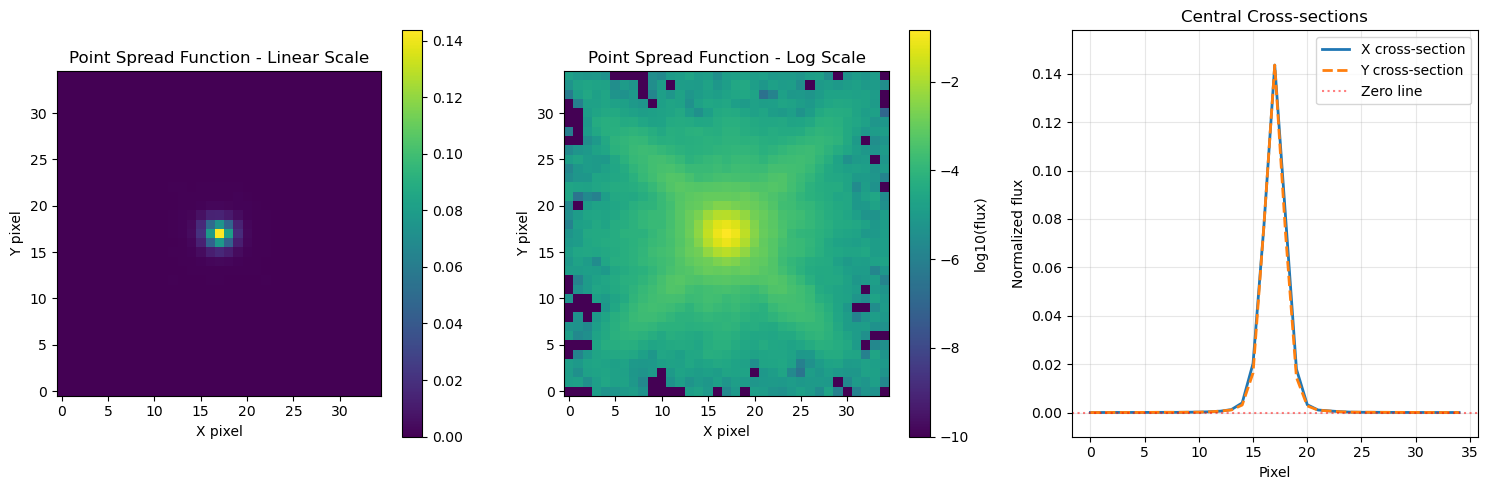


PSF Statistics:
Shape: (35, 35)
Sum: 1.000000
Peak value: 0.143603
FWHM estimate: ~1.49 pixels

NEGATIVE PIXEL ANALYSIS
Number of negative pixels: 61
Percentage of negative pixels: 4.98%
Minimum value: -1.203e-05
Mean of negative values: -3.481e-06
Mean distance of negative pixels from center: 19.1 pixels
Min/Max distance from center: 15.3/24.0 pixels


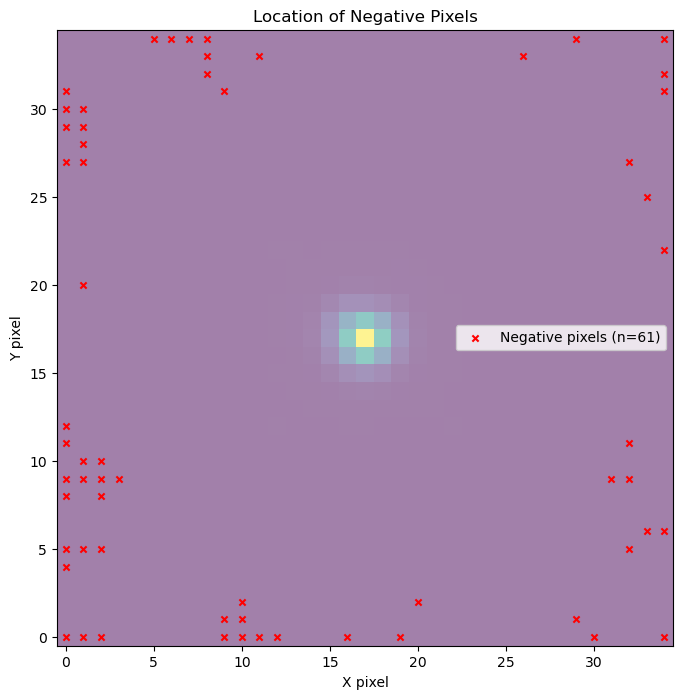


No dead edges detected in final PSF.

PSF creation complete!


In [2]:
# Best cell with all necessary steps. No moffat star region masking is done here.
import numpy as np
import os
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from reproject import reproject_interp
from scipy.optimize import curve_fit
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# ====== PARAMETERS - MODIFY THESE ======
# Directory containing your star images
image_directory = "/Users/shashpal27/Desktop/Imfit/WFI_2026/stars_2"  # <-- Change this to your directory

# PSF size (should be odd number)
psf_size = 35  # <-- Change this to your desired size

# Output filename
output_filename = "/Users/shashpal27/Desktop/Imfit/WFI_2026/stacked_psf.fits"  # <-- Change this to your desired filename

# File pattern (if you want to select specific files)
file_pattern = "*.fits"  # <-- Change if needed (e.g., "star_*.fits")

# ====== PSF CREATOR CLASS ======
class PSFCreator:
    def __init__(self, image_directory, psf_size=35, file_pattern='*.fits'):
        """
        Initialize PSF Creator
        
        Parameters:
        -----------
        image_directory : str
            Directory containing star images
        psf_size : int
            Size of the output PSF (should be odd)
        file_pattern : str
            Pattern to match image files (default: '*.fits')
        """
        self.image_directory = image_directory
        self.psf_size = psf_size if psf_size % 2 == 1 else psf_size + 1  # Ensure odd size
        self.file_pattern = file_pattern
        self.aligned_stars = []
        self.star_info = []  # Store info about each star
        
    def moffat_2d(self, xy, amplitude, x0, y0, alpha, beta, background):
        """
        2D Moffat profile function
        
        Parameters:
        -----------
        xy : tuple of arrays
            x and y coordinate arrays
        amplitude : float
            Peak amplitude
        x0, y0 : float
            Center coordinates
        alpha : float
            Scale parameter
        beta : float
            Shape parameter
        background : float
            Background level
        """
        x, y = xy
        r_squared = (x - x0)**2 + (y - y0)**2
        return amplitude * (1 + r_squared / alpha**2)**(-beta) + background
    
    def fit_moffat_profile(self, image):
        """
        Fit a 2D Moffat profile to an image
        
        Parameters:
        -----------
        image : 2D array
            Star image
            
        Returns:
        --------
        params : tuple
            Fitted parameters (amplitude, x0, y0, alpha, beta, background)
        """
        # Create coordinate arrays
        y, x = np.mgrid[:image.shape[0], :image.shape[1]]
        
        # Initial parameter guesses
        background_guess = np.median(image)
        amplitude_guess = image.max() - background_guess
        y0_guess, x0_guess = np.unravel_index(image.argmax(), image.shape)
        alpha_guess = 2.0
        beta_guess = 2.5
        
        initial_guess = [amplitude_guess, x0_guess, y0_guess, alpha_guess, beta_guess, background_guess]
        
        # Bounds for parameters
        bounds = ([0, 0, 0, 0.1, 1.0, -np.inf],
                  [np.inf, image.shape[1], image.shape[0], 20.0, 10.0, np.inf])
        
        try:
            # Flatten arrays for curve_fit
            xdata = np.vstack((x.ravel(), y.ravel()))
            ydata = image.ravel()
            
            # Fit the Moffat profile
            params, _ = curve_fit(self.moffat_2d, xdata, ydata, 
                                  p0=initial_guess, bounds=bounds, maxfev=5000)
            return params
        except:
            # If fitting fails, return initial guesses
            print("Moffat fitting failed, using centroid method")
            return initial_guess
    
    def background_subtract(self, image, sigma=3):
        """
        Apply sigma-clipped background subtraction
        
        Parameters:
        -----------
        image : 2D array
            Input image
        sigma : float
            Sigma clipping threshold
            
        Returns:
        --------
        bg_subtracted : 2D array
            Background-subtracted image
        """
        # Calculate sigma-clipped statistics
        mean, median, std = sigma_clipped_stats(image, sigma=sigma)
        
        # Subtract the median as background
        bg_subtracted = image - median
        
        return bg_subtracted
    
    def check_star_validity(self, image, x_center, y_center, edge_buffer=None):
        """
        Check if a star is valid (not too close to edges)
        
        Parameters:
        -----------
        image : 2D array
            Input image
        x_center, y_center : float
            Star center coordinates
        edge_buffer : int
            Minimum distance from edge (default: psf_size)
            
        Returns:
        --------
        is_valid : bool
            True if star is valid
        """
        if edge_buffer is None:
            edge_buffer = self.psf_size // 2 + 5  # Add extra buffer
        
        # Check if star is too close to any edge
        if (x_center < edge_buffer or 
            x_center > image.shape[1] - edge_buffer or
            y_center < edge_buffer or 
            y_center > image.shape[0] - edge_buffer):
            return False
        return True
    
    def resample_and_center(self, image, x_center, y_center):
        """
        Resample image to center the star at the central pixel using astropy reproject
        
        Parameters:
        -----------
        image : 2D array
            Input star image
        x_center, y_center : float
            Center coordinates from Moffat fit
            
        Returns:
        --------
        resampled : 2D array
            Resampled image with star centered
        """
        # Calculate the shift needed to center the star
        center_pixel = self.psf_size // 2
        
        # Extract a larger region first to avoid edge effects
        extract_size = self.psf_size + 10  # Extra padding
        half_extract = extract_size // 2
        
        x_int = int(round(x_center))
        y_int = int(round(y_center))
        
        # Calculate bounds for extraction with padding
        y_min = max(0, y_int - half_extract)
        y_max = min(image.shape[0], y_int + half_extract + 1)
        x_min = max(0, x_int - half_extract)
        x_max = min(image.shape[1], x_int + half_extract + 1)
        
        # Extract region
        extracted_region = image[y_min:y_max, x_min:x_max]
        
        # If extracted region is too small, pad it
        if extracted_region.shape[0] < extract_size or extracted_region.shape[1] < extract_size:
            # Calculate padding needed
            pad_top = max(0, half_extract - (y_int - y_min))
            pad_bottom = max(0, half_extract + 1 - (y_max - y_int))
            pad_left = max(0, half_extract - (x_int - x_min))
            pad_right = max(0, half_extract + 1 - (x_max - x_int))
            
            # Use constant padding with background level
            bg_level = np.median(extracted_region[0:5, :].flatten())
            extracted_region = np.pad(extracted_region, 
                                    ((pad_top, pad_bottom), (pad_left, pad_right)), 
                                    mode='constant', constant_values=bg_level)
        
        # Calculate sub-pixel shift relative to the extracted region
        x_center_in_extract = x_center - x_min + (pad_left if 'pad_left' in locals() else 0)
        y_center_in_extract = y_center - y_min + (pad_top if 'pad_top' in locals() else 0)
        
        # Create simple WCS for input image (extracted region)
        input_wcs = WCS(naxis=2)
        input_wcs.wcs.crpix = [1, 1]  # Reference pixel
        input_wcs.wcs.crval = [0, 0]  # Reference value
        input_wcs.wcs.cdelt = [1, 1]  # Pixel scale
        input_wcs.wcs.ctype = ["PIXEL", "PIXEL"]
        
        # Create WCS for output image with the desired shift
        output_wcs = WCS(naxis=2)
        # Shift the reference pixel to center the star
        output_wcs.wcs.crpix = [1 - (x_center_in_extract - extract_size // 2), 
                                1 - (y_center_in_extract - extract_size // 2)]
        output_wcs.wcs.crval = [0, 0]
        output_wcs.wcs.cdelt = [1, 1]
        output_wcs.wcs.ctype = ["PIXEL", "PIXEL"]
        
        # Perform the reprojection
        # Use 'bilinear' for order=1 equivalent, or 'biquadratic' for higher order
        interpolation = 'bilinear' if self.psf_size > 25 else 'biquadratic'
        
        resampled, _ = reproject_interp((extracted_region, input_wcs), 
                                       output_wcs, 
                                       shape_out=(extract_size, extract_size),
                                       order=interpolation)
        
        # Handle NaN values that might be introduced by reproject
        nan_mask = np.isnan(resampled)
        if np.any(nan_mask):
            # Replace NaN with background level
            bg_level = np.nanmedian(resampled[0:5, :].flatten()) if 'bg_level' not in locals() else bg_level
            resampled[nan_mask] = bg_level if not np.isnan(bg_level) else 0
        
        # Extract final PSF-sized region from the center
        start = (extract_size - self.psf_size) // 2
        end = start + self.psf_size
        
        resampled = resampled[start:end, start:end]
        
        # Report negative pixels if any
        neg_pixels = np.sum(resampled < 0)
        if neg_pixels > 0:
            min_val = np.min(resampled)
            print(f"    Found {neg_pixels} negative pixels (min={min_val:.3e}) in resampled star")
        
        return resampled
    
    def load_and_process_images(self):
        """
        Load all star images from directory and process them
        """
        # Get list of image files
        pattern = os.path.join(self.image_directory, self.file_pattern)
        image_files = sorted(glob(pattern))
        
        if len(image_files) == 0:
            raise ValueError(f"No image files found matching pattern: {pattern}")
        
        print(f"Found {len(image_files)} star images")
        
        valid_stars = 0
        rejected_stars = 0
        total_negative_pixels = 0
        
        for i, filepath in enumerate(image_files):
            print(f"Processing image {i+1}/{len(image_files)}: {os.path.basename(filepath)}")
            
            # Load image
            with fits.open(filepath) as hdul:
                image = hdul[0].data.astype(float)
            
            # Apply background subtraction
            image_bg_sub = self.background_subtract(image)
            
            # Fit Moffat profile to find center
            params = self.fit_moffat_profile(image_bg_sub)
            amplitude, x_center, y_center, alpha, beta, background = params
            
            print(f"  Center found at: ({x_center:.2f}, {y_center:.2f})")
            
            # Check if star is valid (not too close to edges)
            if not self.check_star_validity(image, x_center, y_center):
                print(f"  Star rejected: too close to edge")
                rejected_stars += 1
                continue
            
            # Resample and center the star
            centered_star = self.resample_and_center(image_bg_sub, x_center, y_center)
            
            # Count negative pixels
            neg_count = np.sum(centered_star < 0)
            total_negative_pixels += neg_count
            
            # Final quality check - ensure no dead edges
            edge_pixels = np.concatenate([
                centered_star[0, :],  # top edge
                centered_star[-1, :],  # bottom edge
                centered_star[:, 0],  # left edge
                centered_star[:, -1]  # right edge
            ])
            
            if np.sum(edge_pixels == 0) > len(edge_pixels) * 0.1:  # If more than 10% are zeros
                print(f"  Star rejected: dead edges detected")
                rejected_stars += 1
                continue
            
            # Store the aligned star
            self.aligned_stars.append(centered_star)
            self.star_info.append({
                'filename': os.path.basename(filepath),
                'center': (x_center, y_center),
                'amplitude': amplitude,
                'negative_pixels': neg_count
            })
            valid_stars += 1
        
        print(f"\nProcessing complete: {valid_stars} valid stars, {rejected_stars} rejected")
        print(f"Total negative pixels in individual stars: {total_negative_pixels}")
    
    def create_psf(self, method='median'):
        """
        Stack aligned stars to create PSF
        
        Parameters:
        -----------
        method : str
            Stacking method ('median' or 'mean')
            
        Returns:
        --------
        psf : 2D array
            Final PSF
        """
        if len(self.aligned_stars) == 0:
            raise ValueError("No aligned stars available. Run load_and_process_images() first.")
        
        # Convert list to 3D array
        star_stack = np.array(self.aligned_stars)
        
        # Normalize each star before stacking to account for brightness variations
        for i in range(star_stack.shape[0]):
            star_sum = np.sum(star_stack[i])
            if star_sum > 0:
                star_stack[i] = star_stack[i] / star_sum
        
        # Create PSF using specified method
        if method == 'median':
            psf = np.median(star_stack, axis=0)
        elif method == 'mean':
            psf = np.mean(star_stack, axis=0)
        else:
            raise ValueError("Method must be 'median' or 'mean'")
        
        # Final centering check using Moffat fit on the PSF itself
        params = self.fit_moffat_profile(psf)
        _, x_center, y_center, _, _, _ = params
        
        center_pixel = self.psf_size // 2
        if abs(x_center - center_pixel) > 0.5 or abs(y_center - center_pixel) > 0.5:
            print(f"PSF center offset detected: ({x_center:.2f}, {y_center:.2f})")
            print("Applying final centering correction...")
            
            # Use reproject for final centering as well
            # Create WCS objects for the shift
            input_wcs = WCS(naxis=2)
            input_wcs.wcs.crpix = [1, 1]
            input_wcs.wcs.crval = [0, 0]
            input_wcs.wcs.cdelt = [1, 1]
            input_wcs.wcs.ctype = ["PIXEL", "PIXEL"]
            
            output_wcs = WCS(naxis=2)
            output_wcs.wcs.crpix = [1 + (x_center - center_pixel), 
                                    1 + (y_center - center_pixel)]
            output_wcs.wcs.crval = [0, 0]
            output_wcs.wcs.cdelt = [1, 1]
            output_wcs.wcs.ctype = ["PIXEL", "PIXEL"]
            
            psf, _ = reproject_interp((psf, input_wcs), 
                                    output_wcs, 
                                    shape_out=psf.shape,
                                    order='bilinear')
            
            # Handle any NaN values
            nan_mask = np.isnan(psf)
            if np.any(nan_mask):
                psf[nan_mask] = 0
        
        # Normalize PSF
        psf_sum = np.sum(psf)
        if psf_sum > 0:
            psf = psf / psf_sum
        
        return psf
    
    def save_psf(self, psf, output_filename='psf.fits'):
        """
        Save PSF to FITS file
        
        Parameters:
        -----------
        psf : 2D array
            PSF to save
        output_filename : str
            Output filename
        """
        hdu = fits.PrimaryHDU(psf)
        hdu.header['PSFSIZE'] = self.psf_size
        hdu.header['NSTARS'] = len(self.aligned_stars)
        hdu.header['METHOD'] = 'Moffat-aligned median stack (reproject)'
        hdu.header['NEGPIX'] = int(np.sum(psf < 0))
        hdu.header['MINVAL'] = float(np.min(psf))
        hdu.writeto(output_filename, overwrite=True)
        print(f"PSF saved to {output_filename}")

# ====== VISUALIZATION FUNCTION ======
def visualize_psf(psf, title="Point Spread Function"):
    """
    Visualize the PSF
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Linear scale
    im1 = axes[0].imshow(psf, origin='lower', cmap='viridis')
    axes[0].set_title(f'{title} - Linear Scale')
    axes[0].set_xlabel('X pixel')
    axes[0].set_ylabel('Y pixel')
    plt.colorbar(im1, ax=axes[0])
    
    # Log scale - handle negative values properly
    psf_positive = psf.copy()
    psf_positive[psf <= 0] = 1e-10  # Set negative/zero to small positive for log
    psf_log = np.log10(psf_positive)
    im2 = axes[1].imshow(psf_log, origin='lower', cmap='viridis')
    axes[1].set_title(f'{title} - Log Scale')
    axes[1].set_xlabel('X pixel')
    axes[1].set_ylabel('Y pixel')
    plt.colorbar(im2, ax=axes[1], label='log10(flux)')
    
    # Cross-section through center
    center = psf.shape[0] // 2
    axes[2].plot(psf[center, :], label='X cross-section', linewidth=2)
    axes[2].plot(psf[:, center], label='Y cross-section', linewidth=2, linestyle='--')
    axes[2].axhline(y=0, color='red', linestyle=':', alpha=0.5, label='Zero line')
    axes[2].set_xlabel('Pixel')
    axes[2].set_ylabel('Normalized flux')
    axes[2].set_title('Central Cross-sections')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # Set y-axis to show negative values if they exist
    y_min = min(np.min(psf[center, :]), np.min(psf[:, center]))
    y_max = max(np.max(psf[center, :]), np.max(psf[:, center]))
    axes[2].set_ylim(y_min * 1.1 if y_min < 0 else -0.01, y_max * 1.1)
    
    plt.tight_layout()
    plt.show()

# ====== NEGATIVE PIXEL ANALYSIS ======
def analyze_negative_pixels(psf):
    """
    Detailed analysis of negative pixels in the PSF
    """
    neg_mask = psf < 0
    num_neg = np.sum(neg_mask)
    
    if num_neg > 0:
        print("\n" + "="*50)
        print("NEGATIVE PIXEL ANALYSIS")
        print("="*50)
        print(f"Number of negative pixels: {num_neg}")
        print(f"Percentage of negative pixels: {num_neg/psf.size*100:.2f}%")
        print(f"Minimum value: {np.min(psf):.3e}")
        print(f"Mean of negative values: {np.mean(psf[neg_mask]):.3e}")
        
        # Show where negative pixels are located
        neg_y, neg_x = np.where(neg_mask)
        center = psf.shape[0] // 2
        distances = np.sqrt((neg_x - center)**2 + (neg_y - center)**2)
        print(f"Mean distance of negative pixels from center: {np.mean(distances):.1f} pixels")
        print(f"Min/Max distance from center: {np.min(distances):.1f}/{np.max(distances):.1f} pixels")
        
        # Create a visualization of negative pixel locations
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(psf, origin='lower', cmap='viridis', alpha=0.5)
        ax.scatter(neg_x, neg_y, c='red', s=20, marker='x', label=f'Negative pixels (n={num_neg})')
        ax.set_title('Location of Negative Pixels')
        ax.set_xlabel('X pixel')
        ax.set_ylabel('Y pixel')
        ax.legend()
        plt.show()
    else:
        print("\n✓ No negative pixels found in the PSF!")

# ====== MAIN EXECUTION ======
print("PSF Creation Started...")
print("=" * 50)

# Create PSF creator instance
psf_creator = PSFCreator(image_directory, psf_size=psf_size, file_pattern=file_pattern)

# Process all images
psf_creator.load_and_process_images()

# Create the PSF using median stacking
psf = psf_creator.create_psf(method='median')

# Save the PSF
psf_creator.save_psf(psf, output_filename)

# Visualize the PSF
visualize_psf(psf)

# Print some statistics
print(f"\nPSF Statistics:")
print(f"Shape: {psf.shape}")
print(f"Sum: {np.sum(psf):.6f}")
print(f"Peak value: {np.max(psf):.6f}")
print(f"FWHM estimate: ~{2.355 * np.std(np.where(psf > psf.max()/2)):.2f} pixels")

# Detailed negative pixel analysis
analyze_negative_pixels(psf)

# Check for dead edges in final PSF
edge_sum = np.sum(psf[0, :]) + np.sum(psf[-1, :]) + np.sum(psf[:, 0]) + np.sum(psf[:, -1])
if edge_sum < 1e-10:
    print("\nWARNING: Dead edges detected in final PSF!")
else:
    print("\nNo dead edges detected in final PSF.")

print("\nPSF creation complete!")